In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]
import math
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scikitplot.metrics import plot_roc_curve as auc_roc

In [2]:
heart_df = pd.read_csv('heart.csv')

In [3]:
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
#Checking number of unique rows in each feature

heart_df.nunique().sort_values()

sex           2
fbs           2
exang         2
target        2
restecg       3
slope         3
cp            4
thal          4
ca            5
oldpeak      40
age          41
trestbps     49
thalach      91
chol        152
dtype: int64

In [6]:
target = 'target'
labels = ['Healthy Patients','Heart-Disease Patients']
features = [i for i in heart_df.columns.values if i not in [target]]

original_df = heart_df.copy(deep=True)

In [7]:
#Checking number of unique rows in each feature

nu = heart_df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(heart_df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])


            Target Variable Distribution           


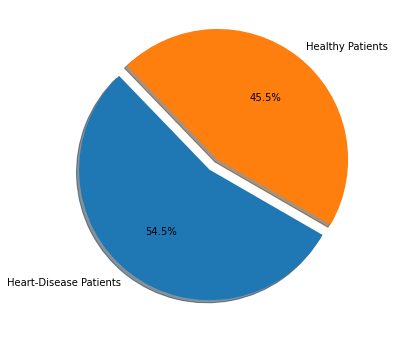

In [8]:
#EDA#

#1. analyze the distribution of the target variable

MAP={}
for e, i in enumerate(sorted(heart_df[target].unique())):
    MAP[i]=labels[e]
#MAP={0:'Not-Survived',1:'Survived'}
df1 = heart_df.copy()
df1[target]=df1[target].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df1[target].value_counts(), labels=df1[target].value_counts().index, counterclock=False, shadow=True, 
        explode=explode, autopct='%1.1f%%', radius=1, startangle=-30)
plt.show()

                                     Features Distribution                                      


C:\Users\Naveena\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Naveena\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Naveena\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

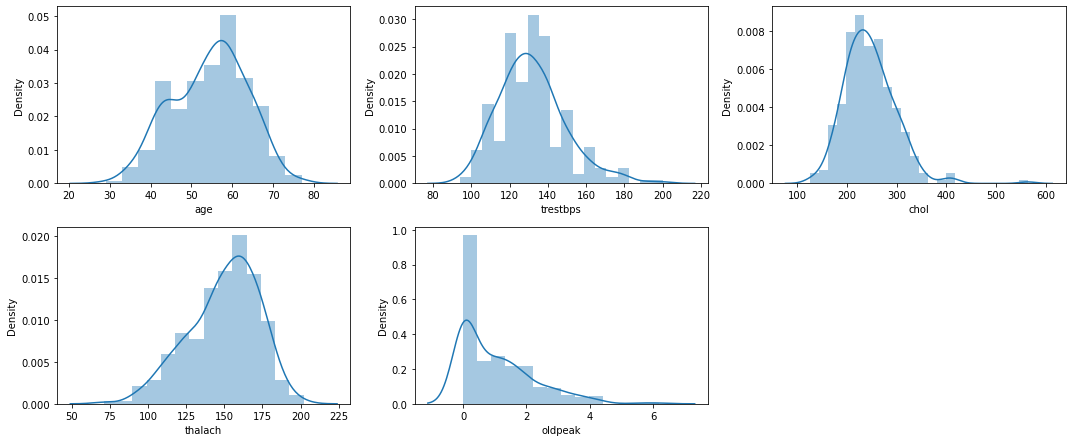

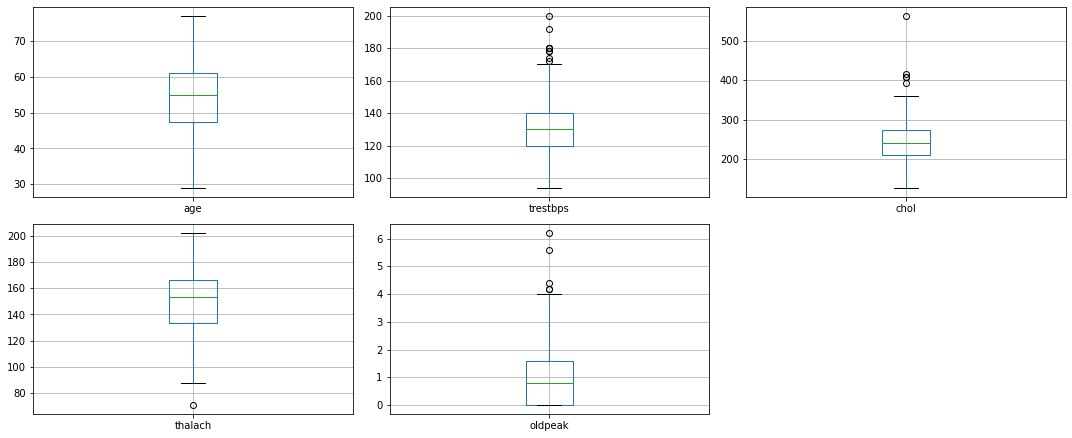

In [9]:
#2. Understanding the feature set

print('\033[1mFeatures Distribution'.center(100))

n=3
nf = [i for i in features if i not in cf]

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),n,c+1)
    sns.distplot(heart_df[nf[c]])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),n,c+1)
    heart_df.boxplot(nf[c])
plt.tight_layout()
plt.show()

In [10]:
#3. Data Preprocessing
#Removal of Duplicate rows

counter = 0
r,c = original_df.shape

df1 = heart_df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df1.shape[0]}')


Inference: Number of duplicates dropped ---> 1


In [11]:
#Checking NULL elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

          Total Null Values  Percentage
age                       0         0.0
sex                       0         0.0
cp                        0         0.0
trestbps                  0         0.0
chol                      0         0.0
fbs                       0         0.0
restecg                   0         0.0
thalach                   0         0.0
exang                     0         0.0
oldpeak                   0         0.0
slope                     0         0.0
ca                        0         0.0
thal                      0         0.0
target                    0         0.0


In [12]:
#Converting categorical Columns to Numeric

#df1 = df.copy()
ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in heart_df.columns if i not in ecc]

# #Target Variable
# MAP={}
# for i,e in enumerate(df1[target].unique()):
#     MAP[e]=i
# df1[target]=df1[target].map(MAP)
# print('Mapping Target variable --->',MAP)

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1m\nOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape


One-Hot Encoding on features:
sex
fbs
exang

Dummy Encoding on features:
restecg
slope
cp
thal
ca


(302, 23)

In [13]:
#Removal of outlier:

df4 = df3.copy()

for i in [i for i in df4.columns]:
    if df4[i].nunique()>=12:
        Q1 = df4[i].quantile(0.25)
        Q3 = df4[i].quantile(0.75)
        IQR = Q3 - Q1
        df4 = df4[df4[i] <= (Q3+(1.5*IQR))]
        df4 = df4[df4[i] >= (Q1-(1.5*IQR))]
df4 = df4.reset_index(drop=True)
display(df4.head())
print('\n\033[1mInference:\033[0m Before removal of outliers, The dataset had {} samples.'.format(df1.shape[0]))
print('\033[1mInference:\033[0m After removal of outliers, The dataset now has {} samples.'.format(df4.shape[0]))

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,restecg_1,...,cp_1,cp_2,cp_3,thal_1,thal_2,thal_3,ca_1,ca_2,ca_3,ca_4
0,63,1,145,233,1,150,0,2.3,1,0,...,0,0,1,1,0,0,0,0,0,0
1,37,1,130,250,0,187,0,3.5,1,1,...,0,1,0,0,1,0,0,0,0,0
2,41,0,130,204,0,172,0,1.4,1,0,...,1,0,0,0,1,0,0,0,0,0
3,56,1,120,236,0,178,0,0.8,1,1,...,1,0,0,0,1,0,0,0,0,0
4,57,0,120,354,0,163,1,0.6,1,1,...,0,0,0,0,1,0,0,0,0,0



Inference: Before removal of outliers, The dataset had 302 samples.
Inference: After removal of outliers, The dataset now has 283 samples.


In [14]:
#Fixing the imbalance using SMOTE Technique

df5 = df4.copy()

print('Original class distribution:')
print(df5[target].value_counts())

xf = df5.columns
X = df5.drop([target],axis=1)
Y = df5[target]

smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

df5 = pd.DataFrame(X, columns=xf)
df5[target] = Y

print('\nClass distribution after applying SMOTE Technique:',)
print(Y.value_counts())


Original class distribution:
1    158
0    125
Name: target, dtype: int64

Class distribution after applying SMOTE Technique:
0    158
1    158
Name: target, dtype: int64


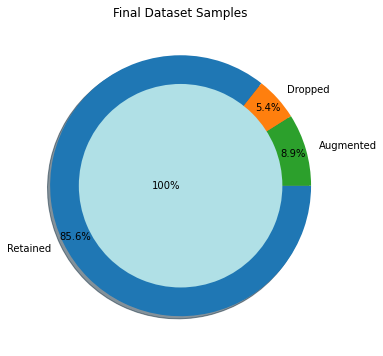


Inference:The final dataset after cleanup has 316 samples & 23 columns.


In [15]:
#Final Dataset size after performing Preprocessing

df = df5.copy()
plt.title('Final Dataset Samples')
plt.pie([df.shape[0], original_df.shape[0]-df4.shape[0], df5.shape[0]-df4.shape[0]], radius = 1, shadow=True,
        labels=['Retained','Dropped','Augmented'], counterclock=False, autopct='%1.1f%%', pctdistance=0.9, explode=[0,0,0])
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78, shadow=True, colors=['powderblue'])
plt.show()

print('\n\033[1mInference:\033[0mThe final dataset after cleanup has {} samples & {} columns.'.format(df.shape[0], df.shape[1]))

In [16]:
#Data Manipulation-- Splitting the df into training and testing
df = df5.copy()

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (316, 22) (316,) 
Training set  --->  (252, 22) (252,) 
Testing set   --->  (64, 22)  (64,)


In [17]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())


                               Standardardization on Training set                               


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,restecg_1,restecg_2,...,cp_1,cp_2,cp_3,thal_1,thal_2,thal_3,ca_1,ca_2,ca_3,ca_4
count,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,...,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02
mean,-8.392757e-17,-2.995840e-17,-5.815454e-16,-3.612630e-17,-7.753939e-17,5.586360e-16,-1.497920e-16,8.591012e-18,1.048544e-16,-2.203925e-16,...,-6.300075e-17,1.682957e-16,-1.762259e-18,1.409807e-17,-8.811294e-18,-1.383373e-16,8.546955e-17,1.251204e-16,9.053604e-17,1.561802e-16
std,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,...,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00,1.001990e+00
min,-2.788447e+00,-1.550937e+00,-2.369034e+00,-2.709776e+00,-3.813850e-01,-2.760902e+00,-6.757569e-01,-9.747538e-01,-9.235481e-01,-8.944272e-02,...,-4.279002e-01,-5.956834e-01,-2.515773e-01,-2.515773e-01,-9.920947e-01,-7.713214e-01,-5.283823e-01,-3.606173e-01,-2.032789e-01,-1.097643e-01
25%,-8.003308e-01,-1.550937e+00,-6.680028e-01,-7.389295e-01,-3.813850e-01,-6.921096e-01,-6.757569e-01,-9.747538e-01,-9.235481e-01,-8.944272e-02,...,-4.279002e-01,-5.956834e-01,-2.515773e-01,-2.515773e-01,-9.920947e-01,-7.713214e-01,-5.283823e-01,-3.606173e-01,-2.032789e-01,-1.097643e-01
50%,1.937274e-01,6.447715e-01,-1.375987e-02,-8.970941e-02,-3.813850e-01,1.331463e-01,-6.757569e-01,-2.268202e-01,-9.235481e-01,-8.944272e-02,...,-4.279002e-01,-5.956834e-01,-2.515773e-01,-2.515773e-01,-9.920947e-01,-7.713214e-01,-5.283823e-01,-3.606173e-01,-2.032789e-01,-1.097643e-01
75%,6.355311e-01,6.447715e-01,6.404831e-01,6.522565e-01,-3.813850e-01,6.757804e-01,1.479822e+00,7.080968e-01,1.082781e+00,-8.944272e-02,...,-4.279002e-01,1.678744e+00,-2.515773e-01,-2.515773e-01,1.007968e+00,1.296476e+00,-5.283823e-01,-3.606173e-01,-2.032789e-01,-1.097643e-01
max,2.513197e+00,6.447715e-01,2.603212e+00,2.715849e+00,2.622022e+00,2.394122e+00,1.479822e+00,2.764914e+00,1.082781e+00,1.118034e+01,...,2.336993e+00,1.678744e+00,3.974921e+00,3.974921e+00,1.007968e+00,1.296476e+00,1.892569e+00,2.773023e+00,4.919350e+00,9.110434e+00



                                Standardardization on Testing set                                


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,restecg_1,restecg_2,...,cp_1,cp_2,cp_3,thal_1,thal_2,thal_3,ca_1,ca_2,ca_3,ca_4
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,6.400000e+01,...,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.024599,0.027229,-0.078162,-0.093332,-0.005959,0.077328,-0.035819,0.003939,0.142314,-8.944272e-02,...,0.004114,0.043999,0.210696,-0.119499,0.132941,-0.028207,-0.150109,0.031088,0.276968,0.034301
std,0.957842,0.995015,1.017729,1.139119,1.001136,1.004529,0.992628,0.912115,1.009118,1.258875e-16,...,1.011847,1.030687,1.329557,0.741193,1.000031,1.000008,0.885978,1.044547,1.504951,1.152525
min,-2.236193,-1.550937,-1.976489,-2.176488,-0.381385,-2.082609,-0.675757,-0.974754,-0.923548,-8.944272e-02,...,-0.427900,-0.595683,-0.251577,-0.251577,-0.992095,-0.771321,-0.528382,-0.360617,-0.203279,-0.109764
25%,-0.579429,-1.550937,-0.668003,-0.907031,-0.381385,-0.771244,-0.675757,-0.974754,-0.923548,-8.944272e-02,...,-0.427900,-0.595683,-0.251577,-0.251577,-0.992095,-0.771321,-0.528382,-0.360617,-0.203279,-0.109764
50%,0.083276,0.644772,-0.144608,-0.205642,-0.381385,0.314024,-0.675757,-0.039837,1.082781,-8.944272e-02,...,-0.427900,-0.595683,-0.251577,-0.251577,1.007968,-0.771321,-0.528382,-0.360617,-0.203279,-0.109764
75%,0.773595,0.644772,0.591415,0.588494,-0.381385,1.003622,1.479822,0.708097,1.082781,-8.944272e-02,...,-0.427900,1.678744,-0.251577,-0.251577,1.007968,1.296476,-0.528382,-0.360617,-0.203279,-0.109764
max,1.850491,0.644772,2.603212,2.553544,2.622022,1.851487,1.479822,2.390947,1.082781,-8.944272e-02,...,2.336993,1.678744,3.974921,3.974921,1.007968,1.296476,1.892569,2.773023,4.919350,9.110434


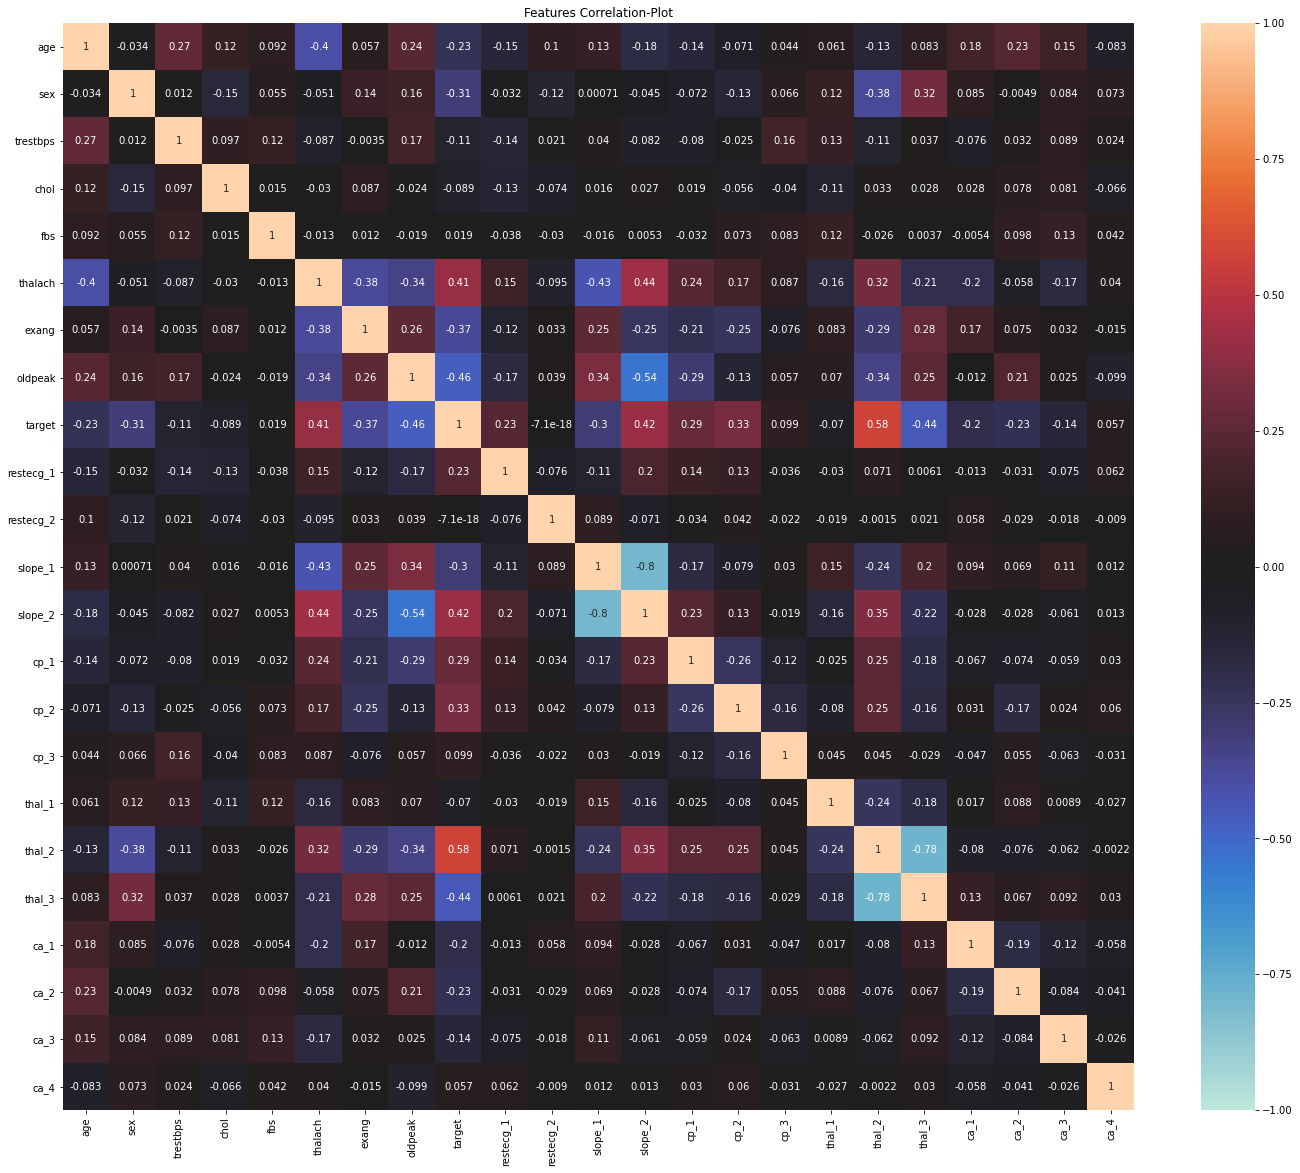

In [18]:
#Feature Selection

#Checking the correlation

features = df.columns
plt.figure(figsize=[24,20])
plt.title('Features Correlation-Plot')
sns.heatmap(df[features].corr(), vmin=-1, vmax=1, center=0, annot=True) #, 
plt.show()

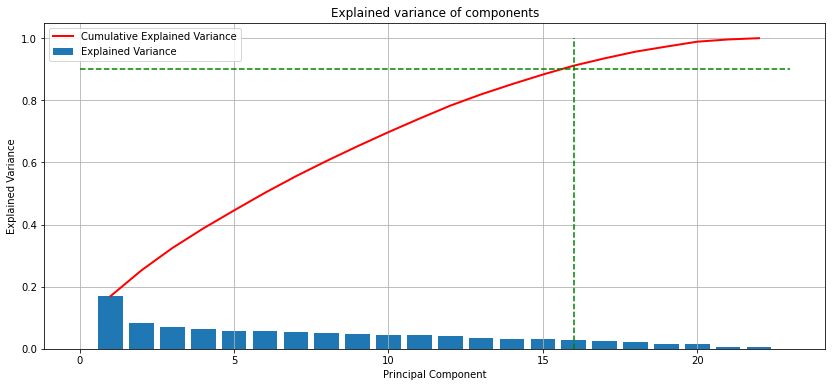

In [19]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(14,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.90,0.90],'g--')
plt.plot([16,16],[0,1], 'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.grid()
plt.legend()
plt.show()

In [20]:
#Let us create first create a table to store the results of various models 

Evaluation_Results = pd.DataFrame(np.zeros((3,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Support Vector Machine (SVM)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Support Vector Machine (SVM),0.0,0.0,0.0,0.0,0.0


In [21]:
#Let us define functions to summarise the Prediction's scores .

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob[:,1], multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) #
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 84.39999999999999%
F1 Score = 84.3%

 Confusiton Matrix:
 [[26  7]
 [ 3 28]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84        33
           1       0.80      0.90      0.85        31

    accuracy                           0.84        64
   macro avg       0.85      0.85      0.84        64
weighted avg       0.85      0.84      0.84        64



C:\Users\Naveena\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


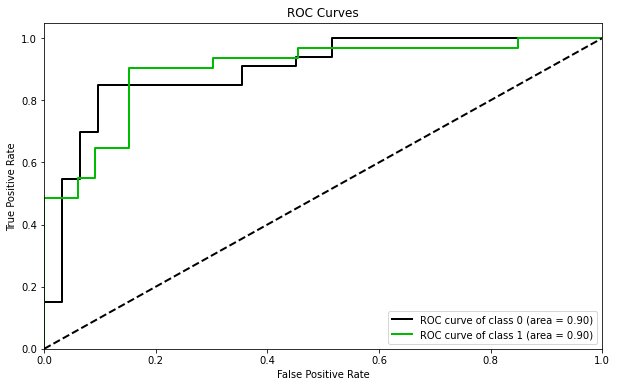

In [22]:
# Building Logistic Regression Classifier

LR_model = LogisticRegression()

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2'] #'none', 'l1', 'l2', 'elasticnet'
space['C'] = loguniform(1e-5, 100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(LR_model, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

LR = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = LR.predict(Test_X_std)
pred_prob = LR.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,0)

#print('\n\033[1mInterpreting the Output of Logistic Regression:\n\033[0m')

#print('intercept ', LR.intercept_[0])
#print('classes', LR.classes_)
#display(pd.DataFrame({'coeff': LR.coef_[0]}, index=Train_X_std.columns))

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 75.0%
F1 Score = 75.0%

 Confusiton Matrix:
 [[25  8]
 [ 8 23]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76        33
           1       0.74      0.74      0.74        31

    accuracy                           0.75        64
   macro avg       0.75      0.75      0.75        64
weighted avg       0.75      0.75      0.75        64



C:\Users\Naveena\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


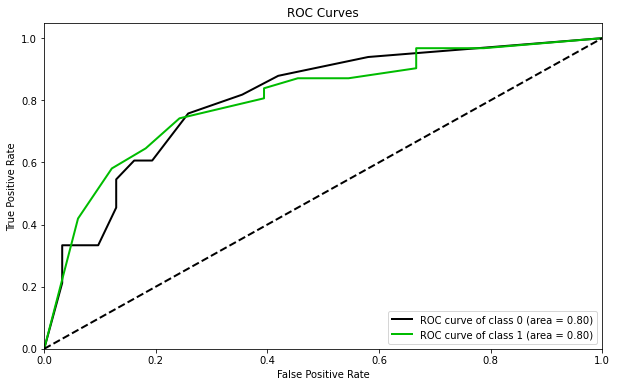

In [23]:
#Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(DT_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

DT = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = DT.predict(Test_X_std)
pred_prob = DT.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,1)

#print('\n\033[1mInterpreting the output of Decision Tree:\n\033[0m')
#tree.plot_tree(DT)
#plt.show()


In [24]:
#!pip install scikit-plot

C:\Users\Naveena\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


<<<----------------------------------- Evaluating Support Vector Machine (SVM) ----------------------------------->>>

Accuracy = 81.2%
F1 Score = 81.2%

 Confusiton Matrix:
 [[25  8]
 [ 4 27]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.76      0.81        33
           1       0.77      0.87      0.82        31

    accuracy                           0.81        64
   macro avg       0.82      0.81      0.81        64
weighted avg       0.82      0.81      0.81        64



C:\Users\Naveena\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


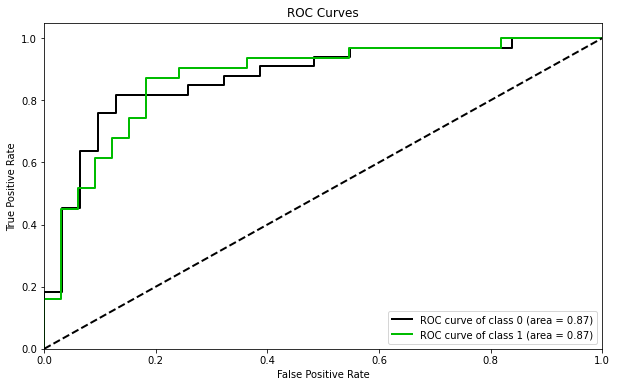

In [25]:
# Building Support Vector Machine Classifier

SVM_model = SVC(probability=True).fit(Train_X_std, Train_Y)

svm_param = {"C": [.01, .1, 1, 5, 10, 100],             
             "gamma": [.01, .1, 1, 5, 10, 100],
             "kernel": ["rbf"],
             "random_state": [1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(SVM_model, svm_param, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

SVM = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = SVM.predict(Test_X_std)
pred_prob = SVM.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,2)

                                    ML Algorithms Comparison                                    


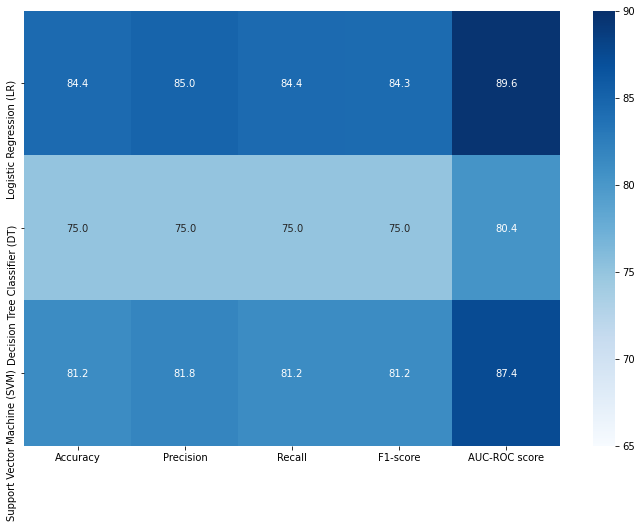

In [26]:
#Comparing all the models Scores

print('\033[1mML Algorithms Comparison'.center(100))
plt.figure(figsize=[12,8])
sns.heatmap(Evaluation_Results, annot=True, vmin=65, vmax=90, cmap='Blues', fmt='.1f')
plt.show()

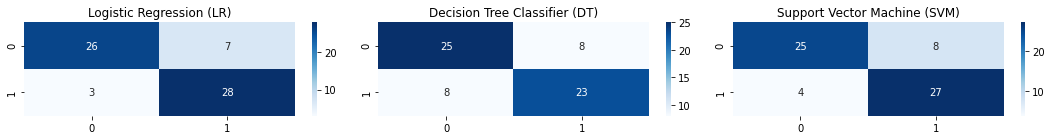

In [27]:
#Plotting Confusion-Matrix of all the predictive Models

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"
    
def conf_mat_plot(all_models):
    plt.figure(figsize=[20,3.5*math.ceil(len(all_models)*len(labels)/14)])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(2,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/3),3,i+1)
        pred = all_models[i].predict(Test_X_std)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, cmap='Blues', fmt='.0f') #vmin=0,vmax=5
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([LR,DT,SVM])